In [20]:
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import pandas as pd # type: ignore
import pingouin as pg # type: ignore
import seaborn as sns # type: ignore
from sklearn.preprocessing import MinMaxScaler # type: ignore
from typing import Union
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option("display.precision", 2)

In [21]:
df = pd.read_csv("emissionssw.dat", sep=" ")
print(df.shape)
df.head()

(2022, 4)


,nox,noxem,ws,humidity
0,170.25,1580.13,0.90,0.32
1,314.40,3248.04,1.05,0.40
2,270.15,3207.56,0.97,0.37
3,177.65,2798.42,1.03,0.31
4,168.00,3181.84,2.02,0.26


In [22]:
TARGET = "nox"
COVARIATES = ["noxem", "ws", "humidity"]

## ***Preprocessing***

In [23]:
def preprocessing(data: pd.DataFrame, mode: str) -> pd.DataFrame:
    def _standardize(s: pd.Series):
        return (s - s.mean()) / s.std()

    if mode == "standardize":
        return data.apply(_standardize, axis=0)

    if mode == "min_max":
        scaler = MinMaxScaler(feature_range=(1e-6, 1))
        X_scaled = scaler.fit_transform(X=data[COVARIATES], y=data[TARGET])
        data[COVARIATES] = pd.DataFrame(X_scaled, columns=COVARIATES)
        return data

In [24]:
df = preprocessing(df, mode="min_max")
df.describe()

,nox,noxem,ws,humidity
count,2022.00,2.02e+03,2.02e+03,2.02e+03
mean,116.02,4.08e-01,1.76e-01,3.97e-02
std,98.39,2.92e-01,1.32e-01,7.05e-02
min,1.20,1.00e-06,1.00e-06,1.00e-06
25%,47.70,1.09e-01,8.28e-02,1.26e-02
50%,88.30,3.96e-01,1.39e-01,2.24e-02
75%,152.50,6.92e-01,2.35e-01,3.89e-02
max,694.50,1.00e+00,1.00e+00,1.00e+00


## ***EDA***

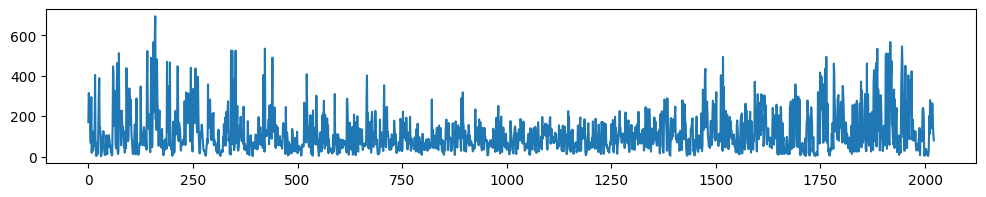

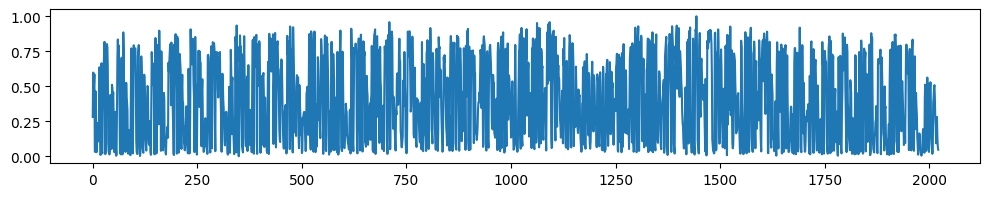

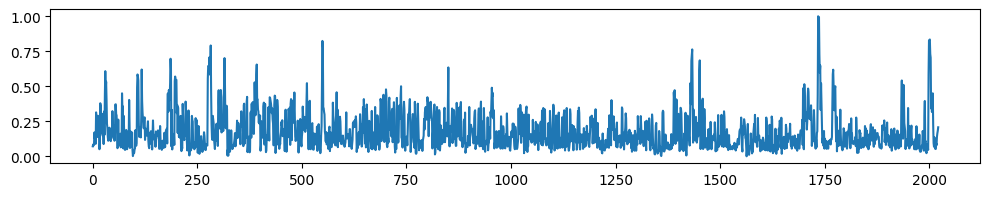

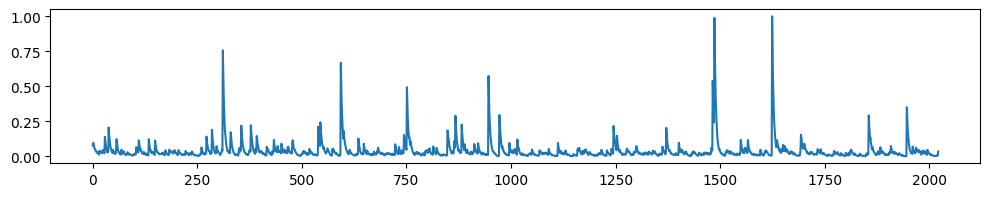

In [25]:
for col in df.columns:
    plt.figure(figsize=(12, 2))
    plt.plot(df[col])

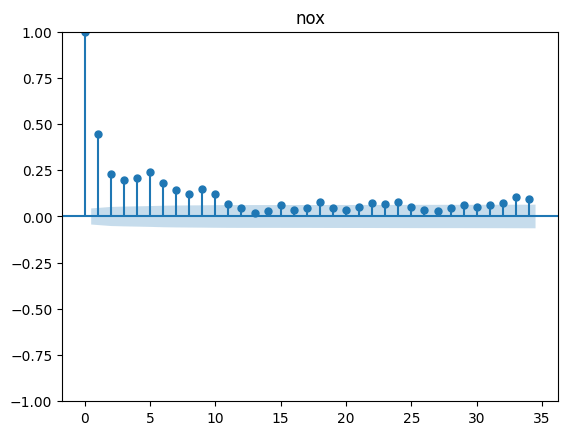

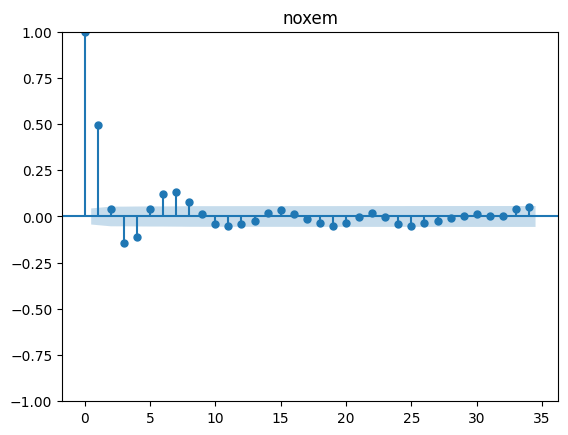

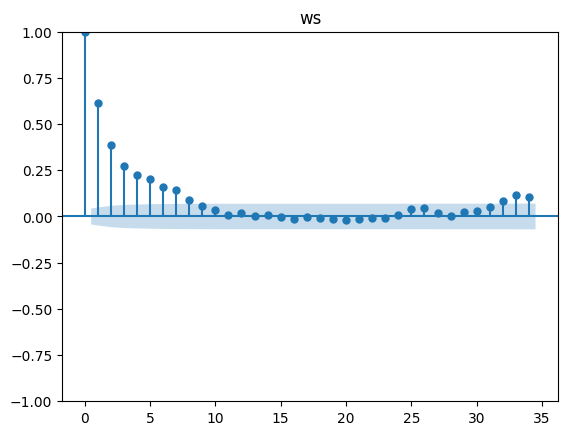

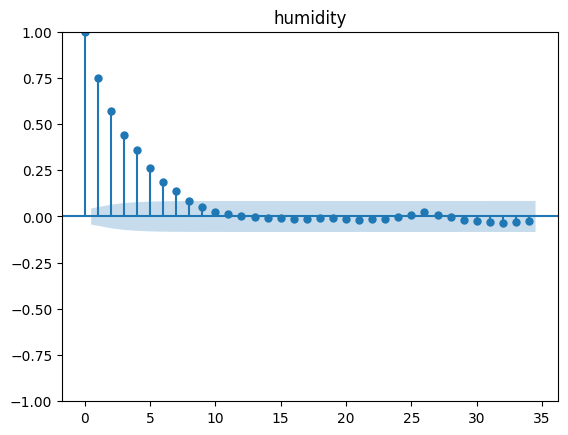

In [26]:
for col in df.columns: 
    plot_acf(df[col])
    plt.title(col)

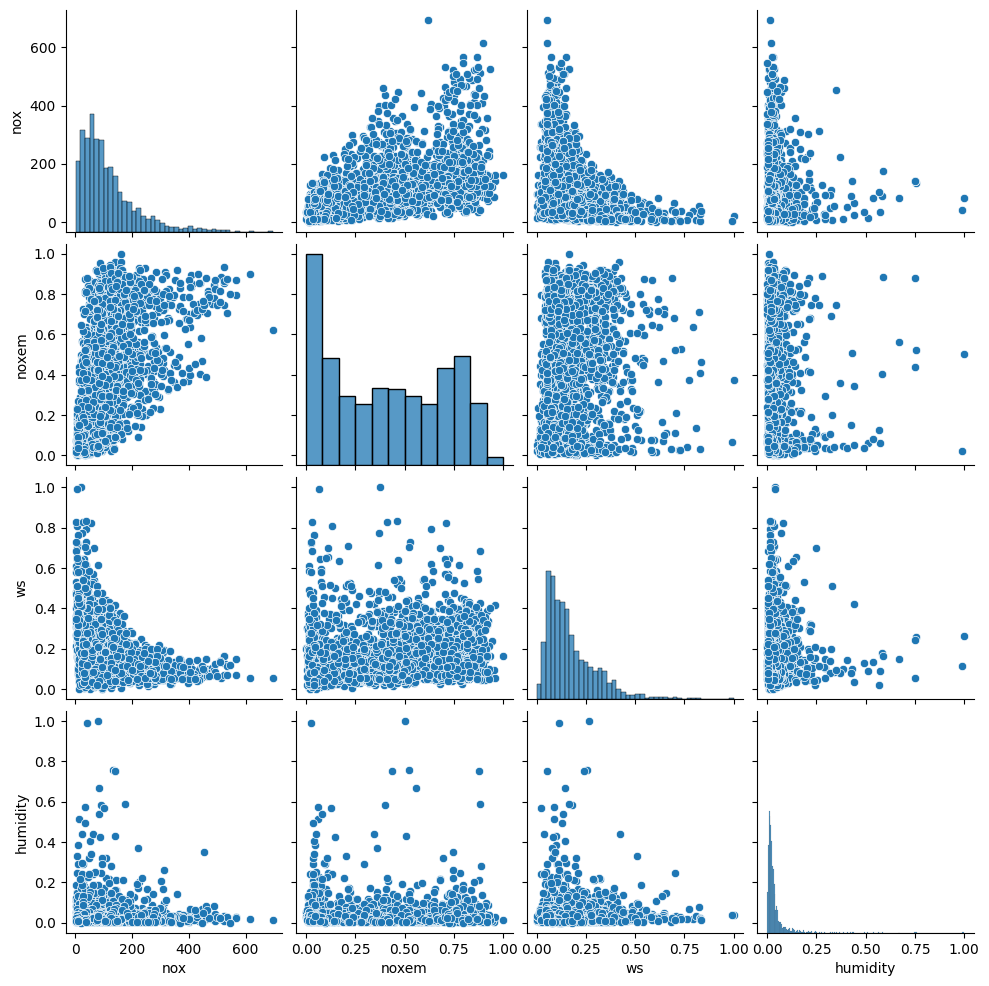

In [27]:
sns.pairplot(df)
plt.show()

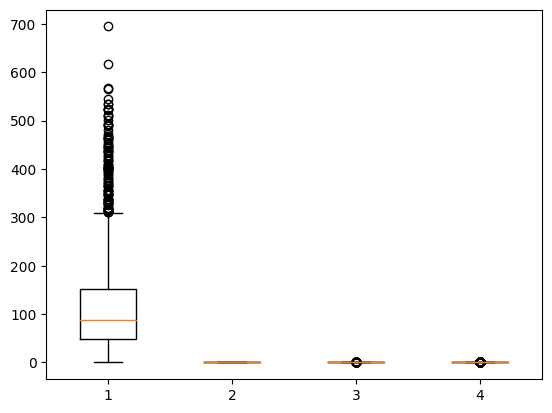

In [28]:
plt.boxplot(df)
plt.show()

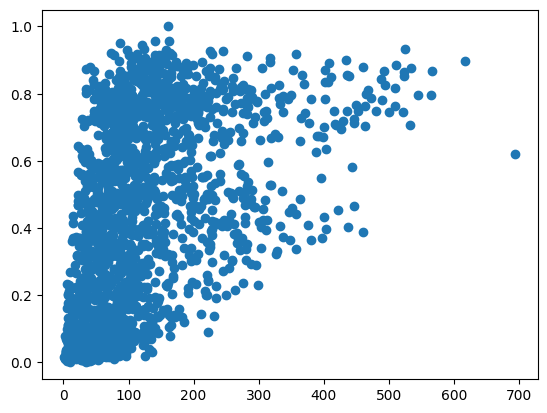

In [29]:
plt.scatter(df[TARGET], (df["noxem"]))
plt.show()

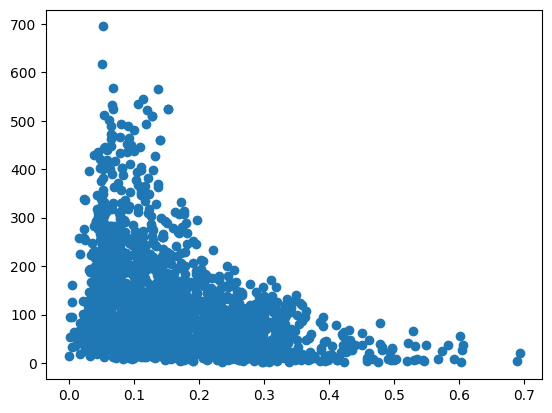

In [30]:
plt.scatter(np.log1p(df["ws"]), df[TARGET])
plt.show()

## ***Feature Selection***

### **Regression with all covariates**

In [31]:
pg.linear_regression(X=df[COVARIATES], y=df[TARGET])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,93.85,3.56,26.36,7.07e-132,0.44,0.44,86.87,100.83
1,noxem,190.15,5.66,33.57,1.03e-196,0.44,0.44,179.04,201.26
2,ws,-308.00,12.54,-24.55,1.06e-116,0.44,0.44,-332.61,-283.40
3,humidity,-29.56,23.33,-1.27,2.05e-01,0.44,0.44,-75.32,16.20


### **Regression with all interactions**

In [32]:
def interactions(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data["ws_noxem"] = data["noxem"] * data["ws"]
    data["ws_humidity"] = data["humidity"] * data["ws"]
    data["humidity_noxem"] = data["noxem"] * data["humidity"]

    return data.drop(columns=TARGET)


interactions_df = interactions(df)
lr = pg.linear_regression(X=interactions_df, y=df[TARGET])
lr

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,59.11,4.89,12.08,1.69e-32,0.47,0.47,49.51,68.70
1,noxem,278.62,9.79,28.45,5.91e-150,0.47,0.47,259.41,297.83
2,ws,-98.33,23.93,-4.11,4.15e-05,0.47,0.47,-145.27,-51.39
3,humidity,-28.34,45.17,-0.63,5.30e-01,0.47,0.47,-116.92,60.23
4,ws_noxem,-504.65,42.84,-11.78,5.00e-31,0.47,0.47,-588.66,-420.64
5,ws_humidity,-31.15,221.20,-0.14,8.88e-01,0.47,0.47,-464.94,402.65
6,humidity_noxem,27.39,81.38,0.34,7.37e-01,0.47,0.47,-132.22,186.99


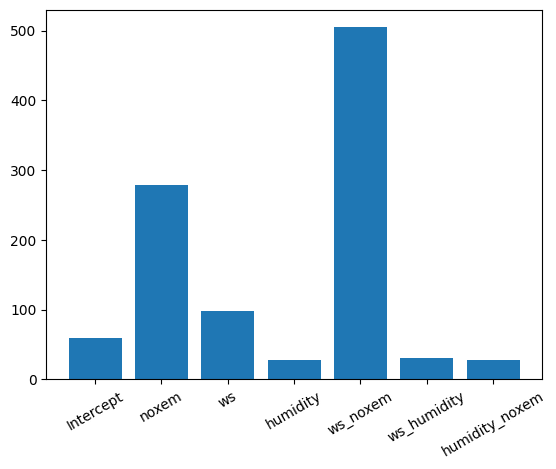

In [33]:
plt.bar(x=lr.names, height=np.abs(lr.coef))
plt.xticks(rotation=30)
plt.show()

In [34]:
def log_features(df: pd.DataFrame) -> pd.DataFrame:
    data = df.copy()
    data["log_ws"] = np.log1p(data["ws"])
    # data["ws_noxem"] = data["noxem"] * data["ws"]
    data = data.drop(columns=["humidity", "ws"])

    return data.drop(columns=TARGET)


lr = pg.linear_regression(X=log_features(df), y=df[TARGET], add_intercept=False)
lr  

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,noxem,281.06,5.50,51.07,0.00e+00,0.68,0.68,270.27,291.85
1,log_ws,-127.27,14.69,-8.66,9.31e-18,0.68,0.68,-156.09,-98.46


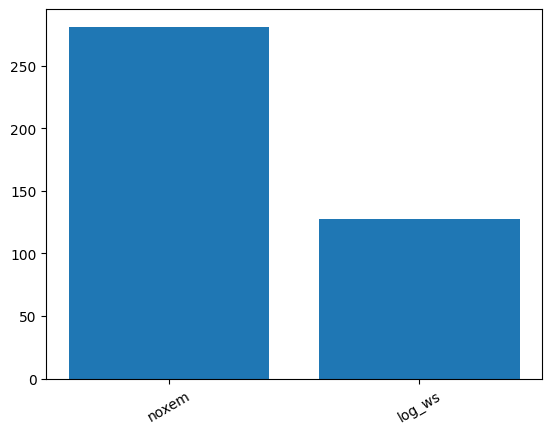

In [35]:
plt.bar(x=lr.names, height=np.abs(lr.coef))
plt.xticks(rotation=30)
plt.show()

In [36]:
def interaction_features(data: pd.DataFrame) -> pd.DataFrame:
    data["ws_noxem"] = data["noxem"] * data["ws"]
    data["nexp_ws"] = -np.exp(data["ws"])
    data = data.drop(columns=["humidity", "ws"])

    return data.drop(columns=TARGET)


lr = pg.linear_regression(
    X=interaction_features(df.copy()), y=df[TARGET], add_intercept=False
)
lr

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,noxem,323.33,6.78,47.67,0.00e+00,0.78,0.78,310.03,336.63
1,ws_noxem,-742.24,24.70,-30.05,2.79e-164,0.78,0.78,-790.69,-693.80
2,nexp_ws,-33.25,2.29,-14.50,2.23e-45,0.78,0.78,-37.75,-28.75


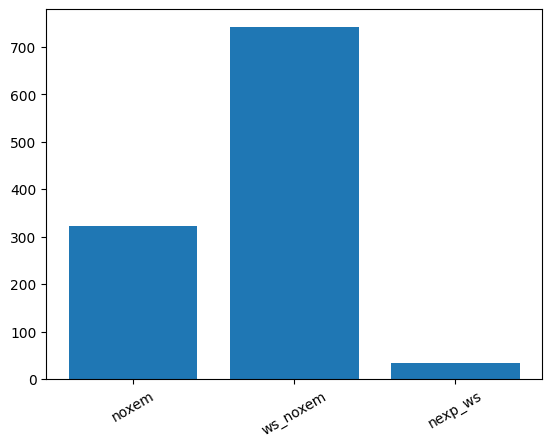

In [37]:
plt.bar(x=lr.names, height=np.abs(lr.coef))
plt.xticks(rotation=30)
plt.show()

## ***Correlations***

In [38]:
pg.corr(df["ws"], df["noxem"])

,n,r,CI95%,p-val,BF10,power
pearson,2022,0.12,"[0.07, 0.16]",1.48e-07,2.735e+04,1.0


In [39]:
pg.corr(df[TARGET], df["ws"])

,n,r,CI95%,p-val,BF10,power
pearson,2022,-0.35,"[-0.39, -0.31]",1.75e-58,7.136e+54,1.0


In [40]:
pg.corr(df[TARGET], df["noxem"])

,n,r,CI95%,p-val,BF10,power
pearson,2022,0.52,"[0.48, 0.55]",5.67e-139,1.233e+135,1.0


## ***Residual analysis***

In [41]:
def get_residuals(
    df: pd.DataFrame,
    feature_selection_fn: Union[callable, None],
    add_intercept: bool,
    robust_regression: bool,
) -> np.ndarray:
    data = df.copy()

    if feature_selection_fn is not None:
        X = feature_selection_fn(data)
    else:
        X = data

    X = X.to_numpy()
    y = data[TARGET]
    lr = pg.linear_regression(X, y, add_intercept=add_intercept)
    weights = np.array(lr.coef)

    if add_intercept:
        bias = np.ones((len(data.index), 1))
        X = np.hstack((bias, X))

    y_hat = X @ weights
    residuals = np.array(y - y_hat)
    print(f"Sum of abs Residuals: {np.sum(np.abs(residuals)):.3f}")


    if robust_regression:
        covariance_matrix = np.diag(residuals**2)
        inv_covariance = np.linalg.inv(covariance_matrix)
        robust_weights = np.linalg.inv(X.T @ inv_covariance @ X) @ (
            X.T @ inv_covariance @ y
        )
        weighted_y_hat = X @ robust_weights

        robust_residuals = np.array(y - weighted_y_hat)
        print(f"Sum of abs Residuals (robust reg): {np.sum(np.abs(robust_residuals)):.3f}")
        return robust_residuals

    else:
        return residuals

In [43]:
lf = log_features(df)
lf["x"] = lf["noxem"] - lf["log_ws"]
lf["z"] = lf["noxem"] + lf["log_ws"]
lf.drop(columns=["noxem", "log_ws"], inplace=True)
lf.head()

,x,z
0,0.21,0.35
1,0.52,0.68
2,0.52,0.66
3,0.43,0.59
4,0.43,0.74


In [48]:
lr = pg.linear_regression(lf, df["nox"], add_intercept=True)
lr

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,100.73,3.55,28.36,3.41e-149,0.45,0.45,93.76,107.69
1,x,297.39,8.69,34.20,1.21e-202,0.45,0.45,280.33,314.44
2,z,-105.37,8.04,-13.11,9.40e-38,0.45,0.45,-121.13,-89.61


Sum of abs Residuals: 98332.307
Sum of abs Residuals: 104404.990
Sum of abs Residuals: 104404.990
Sum of abs Residuals (robust reg): 104407.636


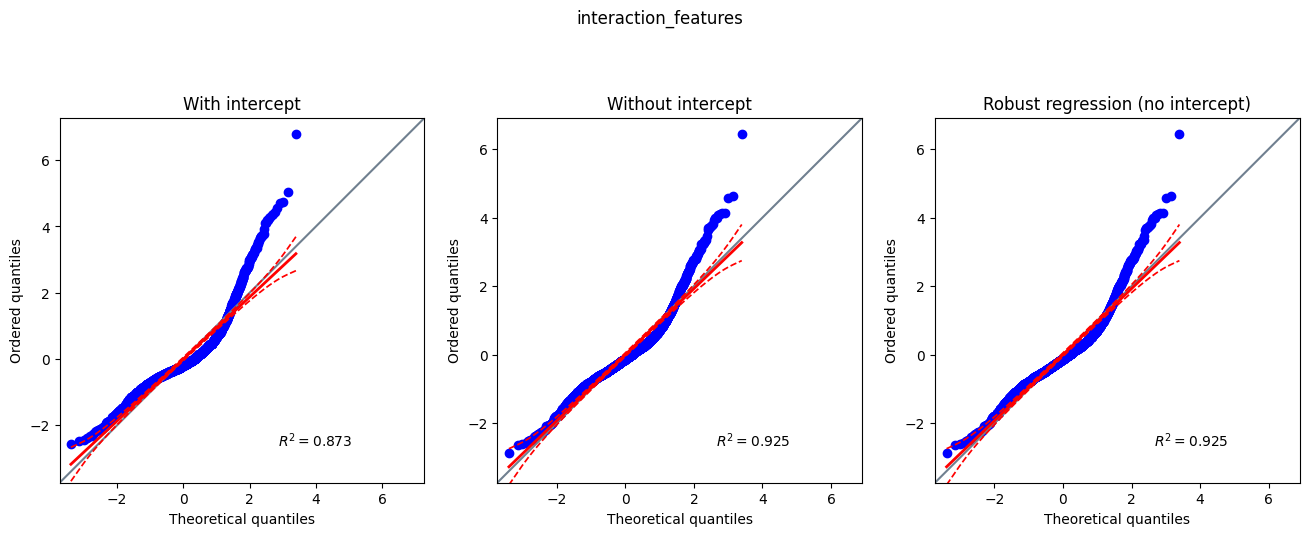

Sum of abs Residuals: 102042.509
Sum of abs Residuals: 130358.733
Sum of abs Residuals: 130358.733
Sum of abs Residuals (robust reg): 130238.567


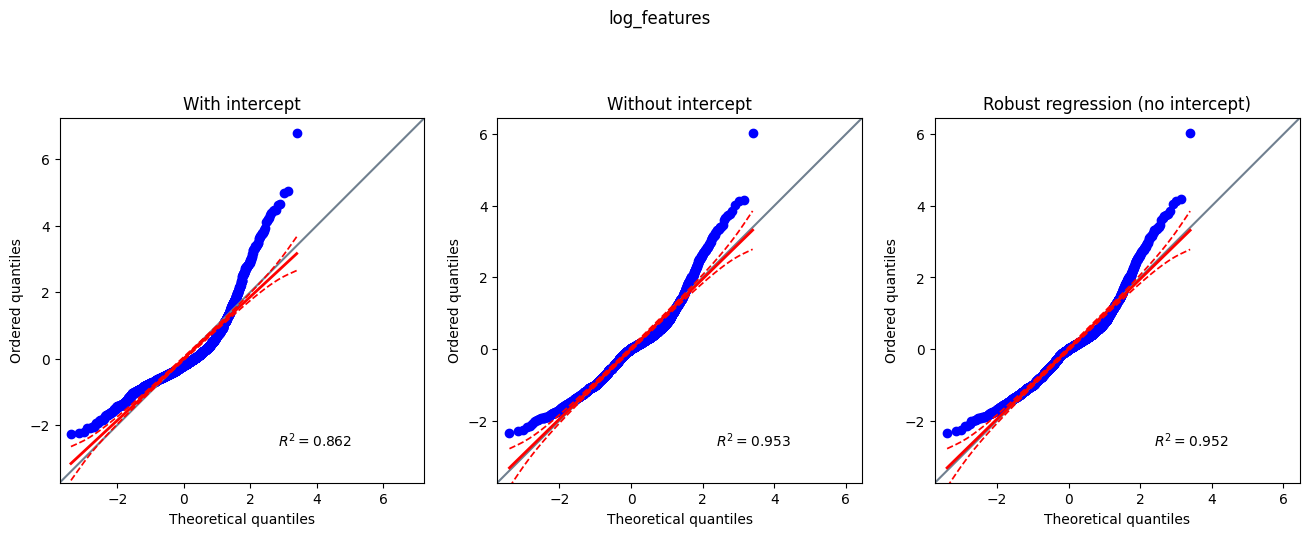

In [23]:
def qq_plot(feature_selection_fn: callable, data: pd.DataFrame,):
    plt.figure(figsize=(16, 6))
    plt.suptitle(f"{feature_selection_fn.__name__}")
    ax1 = plt.subplot(1, 3, 1)
    ax1.set_title("With intercept")
    pg.qqplot(get_residuals(data, feature_selection_fn, add_intercept=True, robust_regression=False))
    ax2 = plt.subplot(1, 3, 2)
    ax2.set_title("Without intercept")
    pg.qqplot(get_residuals(data, feature_selection_fn, add_intercept=False, robust_regression=False))
    ax2 = plt.subplot(1, 3, 3)
    ax2.set_title("Robust regression (no intercept)")
    pg.qqplot(
        get_residuals(
            data, feature_selection_fn, add_intercept=False, robust_regression=True
        )
    )
    plt.show()


qq_plot(interaction_features, df.copy())
qq_plot(log_features, df.copy())

In [24]:
r = get_residuals(df, log_features, add_intercept=False, robust_regression=False)

Sum of abs Residuals: 130358.733


In [25]:
pg.normality(r)

,W,pval,normal
0,0.95,6.26e-25,False


(array([ 87., 422., 717., 550., 137.,  64.,  35.,   9.,   0.,   1.]),
 array([-175.76965085, -105.47385147,  -35.17805209,   35.11774729,
         105.41354668,  175.70934606,  246.00514544,  316.30094483,
         386.59674421,  456.89254359,  527.18834297]),
 <BarContainer object of 10 artists>)

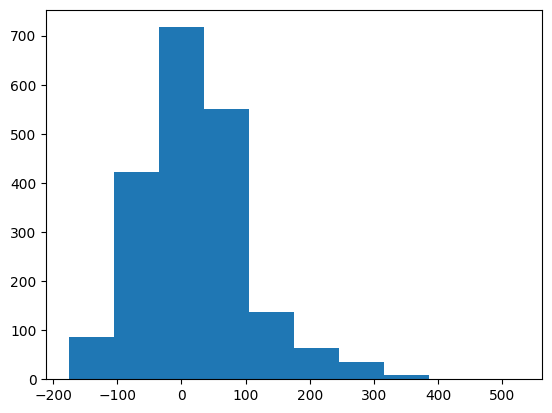

In [26]:
plt.hist(r)